In [1]:
from pycocotools.coco import COCO

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CocoCaptions

from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import Any, Callable, Optional, Tuple, List

import time

In [2]:
coco = COCO("../data/annotations/captions_train2014.json")

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [3]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for img_id in tqdm(list(coco.imgs.keys())):
    annsIds = coco.getAnnIds(imgIds=[img_id])
    caption = coco.loadAnns(annsIds[0])[0]['caption']
    counter.update(tokenizer(caption))
vocab = Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

100%|█████████████████████████████████████████████████████████████████████████| 82783/82783 [00:01<00:00, 80294.03it/s]


In [4]:
bos_index = vocab['<bos>']
eos_index = vocab['<eos>']
pad_index = vocab['<pad>']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def generate_batch(data_batch):
    img_batch, cap_batch, cap_lens = [], [], []
    for (img, cap) in data_batch:
        img_batch.append(img.unsqueeze(0))
        cap_batch.append(cap)
        print(cap.shape)
        cap_lens.append(cap.shape[0])
    
    img_batch = torch.cat(img_batch, dim=0)
    cap_batch = pad_sequence(cap_batch, padding_value=pad_index)
    
    return img_batch, cap_batch, cap_lens

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, hidden_size):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        
        resnet = models.resnet50(pretrained=True)
        
        for params in resnet.parameters(): # will not be fine-tuning resnet
            params.requires_grad = False
        
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1])) # will not be using last layer of resnet since that layer outputs a 1000-D vector for imagenet classification
        self.embedding = nn.Linear(2048, hidden_size) # add a linear layer to get a feature vector to pass into the decoder
        
    def forward(self, inputs):
        output = self.resnet(inputs)
        output = output.view(output.size(0), -1)
        output = self.embedding(output)
        return output

In [33]:
"""
Based on: https://github.com/vedal/show-and-tell
"""
class Decoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_size)
        self.rnn = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size) # word embeddings will be size hidden_size, hidden states will be size hidden_size
        self.out = nn.Linear(in_features=hidden_size, out_features=vocab_size)
    
    def forward(self, features, captions, lengths):
        """
        features: (B, H) set of image feature vectors
        captions: (S, B) set of captions
        lengths: (B) list of caption lengths
        """
        inputs = self.embedding(captions) # inputs: (S, B, H)
        inputs = torch.cat([features.unsqueeze(0), inputs], dim=0) # inputs: (S+1, B, H)
        inputs = nn.utils.rnn.pack_padded_sequence(inputs, lengths, enforce_sorted=False)
        output, _ = self.rnn(inputs) # output: (S+1, B, H)
        output = self.out(output.data) # output: (S+1, B, V)
        return output
    
    def sample(self, features, max_len=25):
        output_ids = []
        states = None
        inputs = features.unsqueeze(1)

        for i in range(max_len):
            # pass data through recurrent network
            hiddens, states = self.rnn(inputs, states)
            outputs = self.out(hiddens.squeeze(0))

            # find maximal predictions
            predicted = outputs.max(1)[1]

            # append results from given step to global results
            output_ids.append(predicted)

            # prepare chosen words for next decoding step
            inputs = self.embedding(predicted)
            inputs = inputs.unsqueeze(0)
        output_ids = torch.stack(output_ids, 0)
        return output_ids.squeeze()

In [9]:
val_dataset_untransformed = CocoCaptions(
root="../data/images/val2014", 
annFile="../data/annotations/captions_val2014.json",
)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


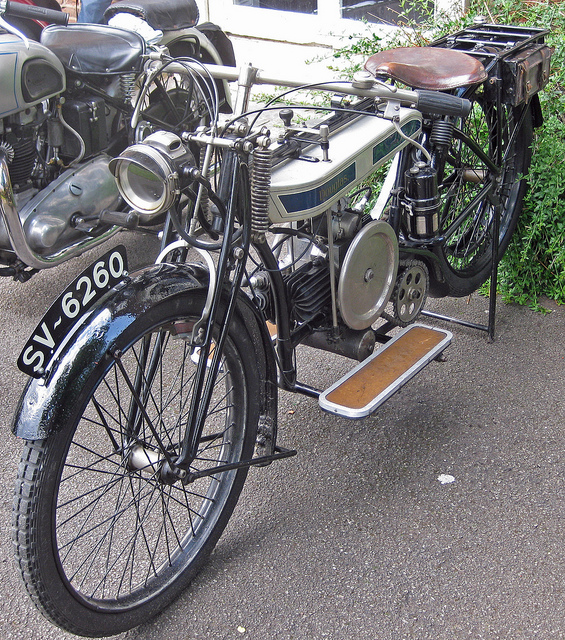

In [10]:
val_dataset_untransformed[1][0]

In [11]:
def sample_caption(encoder, decoder, img, max_len=20):
    greedy_output = torch.zeros(max_len)
    features = encoder(img.unsqueeze(0))
    features = features.view(1, features.shape[0], features.shape[1])
    hidden = features
    cell = features

    decoder_input = torch.full((1, 1), bos_index).to(device)

    for t in range(1, max_len):
        output, (hidden, cell) = decoder(
            decoder_input, hidden,
            cell)  # output: (1, B, V), hidden: (1, B, H), cell: (1, B, H)
        decoder_input = output.argmax(dim=2)  # top1: (1, 1)
        greedy_output[t] = decoder_input

    return greedy_output

In [12]:
def sample_captions(encoder, decoder, img_batch, max_len=20):
    bs = img_batch.shape[0]

    outputs = torch.zeros(max_len, bs,
                          len(vocab)).to(device)  # outputs: (S, B, V)
    features = encoder(img_batch)
    features = features.view(1, features.shape[0], features.shape[1])
    hidden = features
    cell = features

    decoder_input = torch.full((1, bs), bos_index).to(device)  # output: (1, B)

    outputs[0, :, bos_index] = torch.ones(bs)

    for t in range(1, max_len):
        output, (hidden, cell) = decoder(
            decoder_input, hidden,
            cell)  # output: (1, B, V), hidden: (1, B, H), cell: (1, B, H)
        outputs[t] = output

        decoder_input = output.argmax(dim=2)  # output: (1, B)

    return outputs

In [32]:
def train(train_loader, val_loader, encoder, decoder, critereon, optimizer,
          train_losses, val_losses, batch_size, learning_rate, num_epochs, hidden_size):
    for epoch in range(num_epochs):
        train_loss = 0
        # val_loss = 0

        start_time = time.time()

        for images, captions, lengths in tqdm(train_loader):
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()
            features = encoder(images)
            output = decoder(features, captions, lengths)
            
            captions = nn.utils.rnn.pack_padded_sequence(captions, lengths, enforce_sorted=False).data

            loss = critereon(output, captions)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # for images, captions, lengths in tqdm(val_loader):
        #     images, captions = images.to(device), captions.to(device)
            
        #     features = encoder(images)
        #     output = 

        #     output = output[1:].view(-1, output.shape[-1])
        #     captions = captions[1:].view(-1)

        #     loss = critereon(output, captions)

        #     val_loss += loss.item()

        train_loss /= len(train_loader)
        # val_loss /= len(val_loader)

        train_losses.append(train_loss)
        # val_losses.append(val_loss)

        end_time = time.time()

        elapsed_time = end_time - start_time

        torch.save(encoder, "./RNN/models/encoder_{}_{}_{}_{}".format(batch_size, learning_rate, num_epochs, hidden_size))
        torch.save(decoder, "./RNN/models/decoder_{}_{}_{}_{}".format(batch_size, learning_rate, num_epochs, hidden_size))

        print('Epoch: {} | Time: {}s'.format(epoch + 1, elapsed_time))
        print('\tTrain Loss: {}'.format(train_loss))
        # print('\tVal Loss: {}'.format(val_loss))

In [14]:
batch_size = 128
learning_rate = 0.01
num_epochs = 10
hidden_size = 512

In [15]:
def tokenize_caption(cap):
    return torch.cat([
        torch.tensor([bos_index], dtype=torch.long),
        torch.tensor([vocab[token] for token in tokenizer(cap[0])], dtype=torch.long),
        torch.tensor([eos_index], dtype=torch.long)
    ])

In [16]:
train_dataset = CocoCaptions(
root="../data/images/train2014", 
annFile="../data/annotations/captions_train2014.json", 
transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
target_transform=tokenize_caption
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=generate_batch,
    num_workers=4
)

val_dataset = CocoCaptions(
root="../data/images/val2014", 
annFile="../data/annotations/captions_val2014.json", 
transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
target_transform=tokenize_caption
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=generate_batch,
    num_workers=4
)

encoder = Encoder(hidden_size).to(device)
decoder = Decoder(len(vocab), hidden_size).to(device)

critereon = nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [48]:
encoder = torch.load('../RNN/models/encoder_128_0.01_10_512')
decoder = torch.load('../RNN/models/decoder_128_0.01_10_512')

In [49]:
train_losses, val_losses = [], []

In [58]:
test_idx = 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<bos> the snowboarder has jumped high into the air from a snow ramp . <eos>


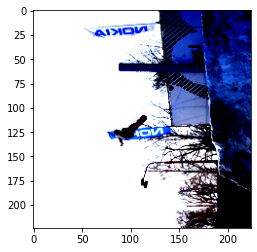

In [59]:
plt.imshow(val_dataset[test_idx][0].transpose(0, 2))
print(" ".join([vocab.itos[idx] for idx in val_dataset[test_idx][1]]))

In [60]:
image, caption = val_dataset[test_idx]
image, caption = image.to(device), caption.to(device)
features = encoder(image.unsqueeze(0))
" ".join([vocab.itos[idx] for idx in decoder.sample(features)])

'<bos> a man riding a skateboard up the side of a ramp . <eos> . <eos> . <eos> . <eos> . <eos> . <eos> .'

In [41]:
train(train_loader, val_loader, encoder, decoder, critereon, optimizer, train_losses, val_losses)

  0%|          | 0/647 [00:06<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 1.96 GiB total capacity; 774.94 MiB already allocated; 323.38 MiB free; 1.05 GiB reserved in total by PyTorch)